In [60]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from scipy.stats import pointbiserialr

from tqdm import tqdm
from gtfparse import read_gtf

import scanpy
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed")


In [36]:
def read_geuvadis(fname_data: Path | str,
                  fname_header: Path | str,
                  fname_gtf: Path | str):
    data_raw = pd.read_csv(fname_data, index_col=0).T
    data_raw = data_raw.astype(np.float32)

    data_header = pd.read_csv(fname_header, index_col=0)

    gtf_rawdata = read_gtf(fname_gtf)
    gtf_data = gtf_rawdata.to_pandas()
    gtf_data = gtf_data.set_index('transcript_id')
    gtf_data['transcript_id'] = gtf_data.index

    gtf_data = gtf_data.drop_duplicates("transcript_id")

    print('Dataset shape: ', data_raw.shape)

    return data_raw, data_header, gtf_data

data_raw, data_header, gtf_data = read_geuvadis(
    fdir_raw / 'Geuvadis.all.csv',
    fdir_raw / 'Geuvadis.SraRunTable.txt',
    fdir_raw / 'all_transcripts_strigtie_merged.gtf'
)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


Dataset shape:  (667, 338725)


In [37]:
data_raw = data_raw[data_raw.columns.intersection(gtf_data.index)]
gtf_data = gtf_data.loc[data_raw.columns.intersection(gtf_data.index)]

In [75]:
adata = anndata.AnnData(data_raw)
adata.var = gtf_data
adata.obs = data_header

adata

AnnData object with n_obs × n_vars = 667 × 338725
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id', 'highly_variable', 'highly_variable_rank'

In [76]:
adata.layers["counts"] = adata.X.copy()
scanpy.pp.normalize_total(adata)
scanpy.pp.log1p(adata)
adata.obs_names_make_unique()

In [77]:
adata

AnnData object with n_obs × n_vars = 667 × 338725
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id', 'highly_variable', 'highly_variable_rank'

In [78]:
scanpy.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    layer="counts",
    batch_key="Experimental_Factor:_laboratory (exp)",
    subset=True,
)
adata

/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


AnnData object with n_obs × n_vars = 667 × 2000
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id', 'highly_variable', 'highly_variable_rank', 

In [79]:
scanpy.tl.pca(adata, 2)
adata.obsm['X_pca'].shape

(667, 2)

<Axes: >

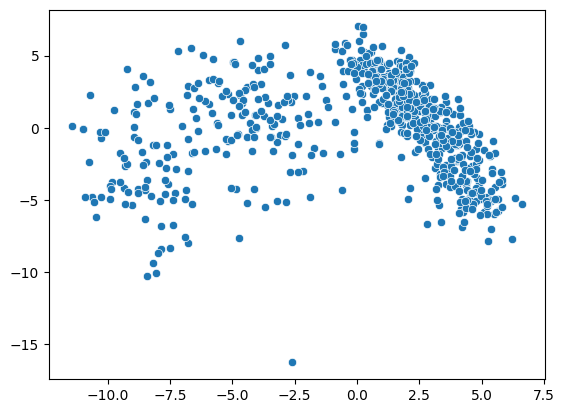

In [81]:
sns.scatterplot(
    x=adata.obsm['X_pca'][:,0],
    y=adata.obsm['X_pca'][:,1],
    )